In [19]:
from sklearn import cross_validation,grid_search,linear_model,metrics,pipeline,preprocessing

In [20]:
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [21]:
raw_data=pd.read_csv("bike_sharing_demand.csv",header=0,sep=",")

In [22]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [23]:
raw_data.datetime=raw_data.datetime.apply(pd.to_datetime)

In [24]:
raw_data["month"]=raw_data.datetime.apply(lambda x:x.month)
raw_data["hour"]=raw_data.datetime.apply(lambda x:x.hour)

In [25]:
train_data=raw_data.iloc[:-1000,:]
hold_out_test_data=raw_data.iloc[-1000:,:]

In [26]:
print raw_data.shape,train_data.shape,hold_out_test_data.shape

(10886, 14) (9886, 14) (1000, 14)


In [27]:
train_labels=train_data["count"].values
train_data=train_data.drop(["datetime","count","casual","registered"],axis=1)

In [28]:
test_labels=hold_out_test_data["count"].values
test_data=hold_out_test_data.drop(["datetime","count","casual","registered"],axis=1)

In [32]:
binary_data_columns=["holiday","workingday"]
binary_data_indices=np.array([(column in binary_data_columns) for column in train_data.columns],dtype=bool)

In [33]:
print binary_data_columns
print binary_data_indices

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [34]:
categorial_data_columns=["season","weather","month"]
categorial_data_indices=np.array([(column in categorial_data_columns) for column in train_data.columns],dtype=bool)

In [35]:
print categorial_data_columns
print categorial_data_indices

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [42]:
numeric_data_columns=["temp","atemp","humidity","windspeed","hour"]
numeric_data_indices=np.array([(column in numeric_data_columns)for column in train_data.columns],dtype=bool)

In [43]:
print numeric_data_columns
print numeric_data_indices

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


In [44]:
regressor=linear_model.SGDRegressor(random_state=0,n_iter=3,loss="squared_loss",penalty="l2")

In [48]:
estimator=pipeline.Pipeline(steps=[
    ("feature_processing",pipeline.FeatureUnion(transformer_list=[
        ("binary_variables_processing",preprocessing.FunctionTransformer(lambda data: data[:,binary_data_indices])),
        ("numeric_variables_processing",pipeline.Pipeline(steps=[
            ("selecting",preprocessing.FunctionTransformer(lambda data: data[:,numeric_data_indices])),
            ("scaling",preprocessing.StandardScaler(with_mean=0.))
        ])),
        ("categorical_variables_processing",pipeline.Pipeline(steps=[
            ("selecting",preprocessing.FunctionTransformer(lambda data: data[:,categorial_data_indices])),
            ("hot_encoding",preprocessing.OneHotEncoder(handle_unknown="ignore"))
        ])),
    ])),
    ("model_fitting",regressor)
])

In [49]:
estimator.fit(train_data,train_labels)

C:\Users\dim\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000000E359F98>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
         ...,
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

In [50]:
metrics.mean_absolute_error(test_labels,estimator.predict(test_data))

120.17177172806858

In [51]:
estimator.get_params().keys()

['feature_processing__binary_variables_processing__pass_y',
 'feature_processing__binary_variables_processing__func',
 'feature_processing__numeric_variables_processing__selecting__kw_args',
 'model_fitting__learning_rate',
 'feature_processing__n_jobs',
 'feature_processing__numeric_variables_processing__selecting',
 'feature_processing__categorical_variables_processing__selecting__kw_args',
 'feature_processing__numeric_variables_processing__scaling__with_std',
 'feature_processing__categorical_variables_processing__selecting__pass_y',
 'feature_processing__categorical_variables_processing__selecting__accept_sparse',
 'feature_processing__transformer_weights',
 'feature_processing__categorical_variables_processing__hot_encoding__n_values',
 'model_fitting__fit_intercept',
 'feature_processing__numeric_variables_processing__selecting__inverse_func',
 'feature_processing',
 'model_fitting__epsilon',
 'feature_processing__categorical_variables_processing__hot_encoding__handle_unknown',


In [56]:
parameters_grid={
    "model_fitting__alpha":[0.0001,0.001,0.1],
    "model_fitting__eta0":[0.001,0.05]
}

In [57]:
grid_cv=grid_search.GridSearchCV(estimator,parameters_grid,scoring="mean_absolute_error",cv=4)

In [58]:
%%time
grid_cv.fit(train_data,train_labels)

C:\Users\dim\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\dim\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dim\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\dim\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dim\Anaconda2\lib\site-packages\sklearn\linear_

C:\Users\dim\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\dim\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dim\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\dim\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dim\Anaconda2\lib\site-packages\sklearn\linear_

Wall time: 3.02 s


C:\Users\dim\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000000E359F98>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
         ...,
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__eta0': [0.001, 0.05], 'model_fitting__alpha': [0.0001, 0.001, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [59]:
print grid_cv.best_score_
print grid_cv.best_params_

-104.61097793
{'model_fitting__eta0': 0.05, 'model_fitting__alpha': 0.1}


In [60]:
test_predictions=grid_cv.best_estimator_.predict(test_data)

In [61]:
metrics.mean_absolute_error(test_labels,test_predictions)

126.17670701473044

In [62]:
print test_labels[:20]

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [63]:
print test_predictions[:20]

[ 143.24020824  166.18559326  212.41847539  243.66840089  262.21027027
  255.95729611  280.35929884  307.46605276  313.16392458  323.56466813
  320.60577642  313.12562495  294.67280622  279.49996563  269.67904685
  240.31743647  244.881957     52.82798241   60.3789872    67.92999199]


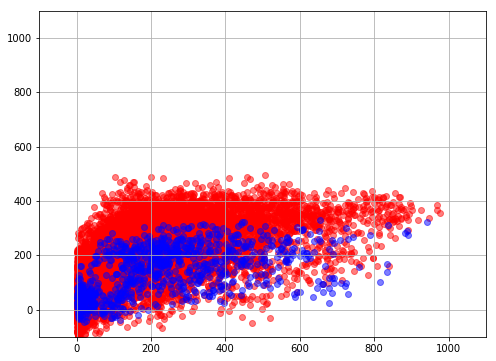

In [64]:
pylab.figure(figsize=(8, 6))
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')

In [65]:
from sklearn.ensemble import RandomForestRegressor

In [66]:
regressor=RandomForestRegressor(random_state=0,max_depth=20,n_estimators=50)

In [69]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorial_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [70]:
estimator.fit(train_data,train_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000001060AC18>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
         ..._estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [71]:
metrics.mean_absolute_error(test_labels,estimator.predict(test_data))

79.477281539788123

In [72]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [73]:
estimator.predict(test_data)[:10]

array([ 409.565     ,  505.56      ,  256.06066667,  165.6502619 ,
        205.82474784,  265.91960439,  254.49615818,  317.85774486,
        280.98963263,  441.59333333])

Text(0.5,1,u'random forest model')

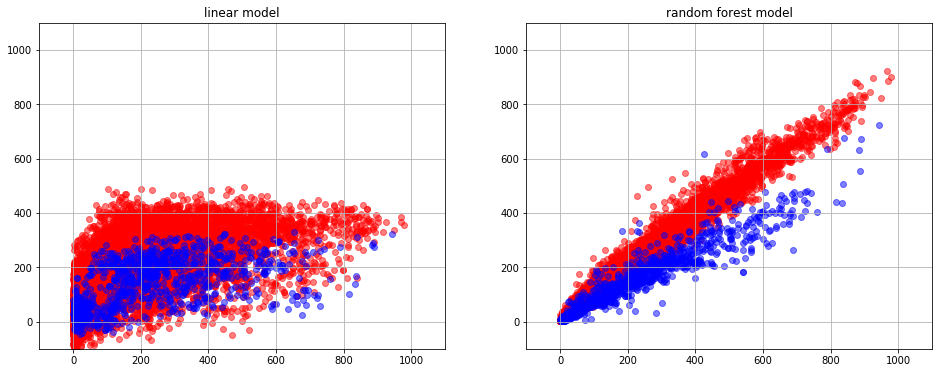

In [74]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')